In [2]:
import sys
import os
import torch

sys.path.append(os.path.abspath("../utils"))
sys.path.append(os.path.abspath("../models"))
sys.path.append("/root/Implementation")  # 假设 scripts 在 /root/scripts 下


In [3]:

sys.path.append("../models")

from simple_cnn import Simple3DCNNEncoder
from encoder3D import SparseEncoder
from decoder3D import LightDecoder
from AnatoMask import SparK

/root/miniconda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/root/miniconda/lib/python3.8/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [4]:
# ==== 自动选择设备 ====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [5]:
# 假设输入尺寸为 [2, 1, 64, 64, 64]
import torch

# 初始化模块
input_size = (64, 64, 64)
cnn = Simple3DCNNEncoder(in_channels=1, base_channels=64)
sparse_encoder = SparseEncoder(cnn, input_size=input_size, sbn=False)
decoder = LightDecoder(up_sample_ratio=8, width=256, sbn=False)
model = SparK(sparse_encoder, decoder, mask_ratio=0.6)

# 模拟输入
x = torch.randn(2, 1, 64, 64, 64)

# 前向传播
inp, rec = model(x)

# 打印重建误差
loss, _ = model.forward_loss(inp, rec, model.mask(x.shape[0], x.device))
print("Reconstruction Loss:", loss.item())


[SparK.__init__, densify 1/3]: use nn.Identity() as densify_proj
[SparK.__init__, densify 2/3]: densify_proj(ksz=3, #para=0.44M)
[SparK.__init__, densify 3/3]: densify_proj(ksz=3, #para=0.11M)
[SparK.__init__] dims of mask_tokens=(256, 128, 64)
Reconstruction Loss: 1.0135107040405273


In [6]:
import torch

# 模拟输入
x = torch.randn(2, 1, 64, 64, 64)

# 1️⃣ 随机 mask
random_mask = model.mask(x.shape[0], x.device)

# 2️⃣ 用随机掩码做第一次重建，获取 patch 级别 loss
inp, rec = model(x, active_b1ff=random_mask)
loss, patch_loss = model.forward_loss(inp, rec, random_mask)

print("Step 1: loss from random masking:", loss.item())

# 3️⃣ 使用 patch loss 生成 AnatoMask 掩码
anatomask_mask, _ = model.generate_mask(patch_loss, guide=True, epoch=0, total_epoch=1000)

# 4️⃣ 用 AnatoMask 掩码再训练一轮
inp2, rec2 = model(x, active_b1ff=anatomask_mask)
loss2, _ = model.forward_loss(inp2, rec2, anatomask_mask)

print("Step 2: loss from AnatoMask-guided masking:", loss2.item())



Step 1: loss from random masking: 1.0100849866867065
Step 2: loss from AnatoMask-guided masking: 1.0105282068252563


In [7]:
def save_checkpoint(model, optimizer, epoch, path):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
    }, path)

def load_checkpoint(model, optimizer, path, device):
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    return model, optimizer, epoch


In [8]:
import torch
import torch.optim as optim

from checkpoint import save_checkpoint, load_checkpoint

# === 保存目录 ===
save_path = "checkpoints/anatomask_spark.pth"

# === 创建保存目录 ===
import os
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# ==== 自动选择设备 ====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ==== 模型移到 GPU ====
model = model.to(device)
model.train()

# ==== 初始化优化器 ====
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# ==== 模拟参数（符合真实数据结构）====
batch_size = 2
in_channels = 1
img_size = (64, 64, 64)  # 你后面可以替换为真实 patch size

# ==== 开始训练循环 ====
epochs = 5

loss_history = []
for epoch in range(epochs):
    # === 模拟输入数据（之后可替换成 DataLoader） ===
    x = torch.randn(batch_size, in_channels, *img_size).to(device)

    # === 1. 初始随机掩码，用于生成loss map ===
    random_mask = model.mask(x.shape[0], device)

    # === 2. 第一次 forward，获得 patch-wise loss map ===
    inp, rec = model(x, active_b1ff=random_mask)
    _, patch_loss = model.forward_loss(inp, rec, random_mask)

    # === 3. 生成 anatomask 掩码（loss guided）===
    anatomask_mask, _ = model.generate_mask(
        loss_pred=patch_loss, guide=True, epoch=epoch, total_epoch=epochs
    )

    # === 4. 第二次 forward，用 AnatoMask 掩码正式训练 ===
    inp2, rec2 = model(x, active_b1ff=anatomask_mask)
    loss, _ = model.forward_loss(inp2, rec2, anatomask_mask)

    # === 5. 优化 ===
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())
    print(f"[Epoch {epoch+1}/{epochs}] Reconstruction Loss: {loss.item():.6f}")
        
    # === 保存每个 epoch 的模型 ===
    save_checkpoint(model, optimizer, epoch, save_path)
    print(f"✅ 模型已保存: {save_path}")

Using device: cuda
[Epoch 1/5] Reconstruction Loss: 1.010636
✅ 模型已保存: checkpoints/anatomask_spark.pth
[Epoch 2/5] Reconstruction Loss: 1.011408
✅ 模型已保存: checkpoints/anatomask_spark.pth
[Epoch 3/5] Reconstruction Loss: 1.009250
✅ 模型已保存: checkpoints/anatomask_spark.pth
[Epoch 4/5] Reconstruction Loss: 1.008616
✅ 模型已保存: checkpoints/anatomask_spark.pth
[Epoch 5/5] Reconstruction Loss: 1.008428
✅ 模型已保存: checkpoints/anatomask_spark.pth


In [9]:
# 恢复模型
model, optimizer, start_epoch = load_checkpoint(model, optimizer, save_path, device)
print(f"恢复模型成功，从 epoch {start_epoch+1} 继续")

恢复模型成功，从 epoch 5 继续


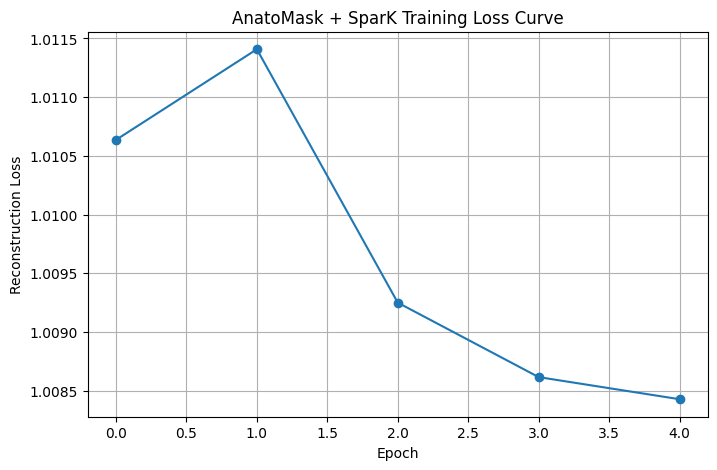

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(loss_history, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Loss")
plt.title("AnatoMask + SparK Training Loss Curve")
plt.grid(True)
plt.show()

In [14]:
def train_one_epoch(model, optimizer, device, epoch, total_epochs, dataloader):
    model.train()
    epoch_loss = []

    for x in dataloader:
        x = x.to(device)

        # mask1 → forward1 → patch_loss
        rand_mask = model.mask(x.shape[0], device)
        inp, rec = model(x, active_b1ff=rand_mask)
        _, patch_loss = model.forward_loss(inp, rec, rand_mask)

        # mask2 → forward2 → train
        anatomask_mask, _ = model.generate_mask(
            patch_loss, guide=True, epoch=epoch, total_epoch=total_epochs
        )
        inp2, rec2 = model(x, active_b1ff=anatomask_mask)
        loss, _ = model.forward_loss(inp2, rec2, anatomask_mask)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.item())

    return sum(epoch_loss) / len(epoch_loss)


In [15]:
def train(model, optimizer, device, epochs, dataloader, save_path=None):
    loss_history = []

    for epoch in range(epochs):
        loss = train_one_epoch(model, optimizer, device, epoch, epochs, dataloader)
        loss_history.append(loss)

        print(f"[Epoch {epoch+1}/{epochs}] Loss: {loss:.6f}")

        if save_path:
            save_checkpoint(model, optimizer, epoch, save_path)
            print(f"✅ 模型已保存: {save_path}")

    # 画图
    import matplotlib.pyplot as plt
    plt.plot(loss_history, marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.grid(True)
    plt.show()

[Epoch 1/5] Loss: 0.998991
[Epoch 2/5] Loss: 0.998106
[Epoch 3/5] Loss: 0.998087
[Epoch 4/5] Loss: 0.998080
[Epoch 5/5] Loss: 0.998077


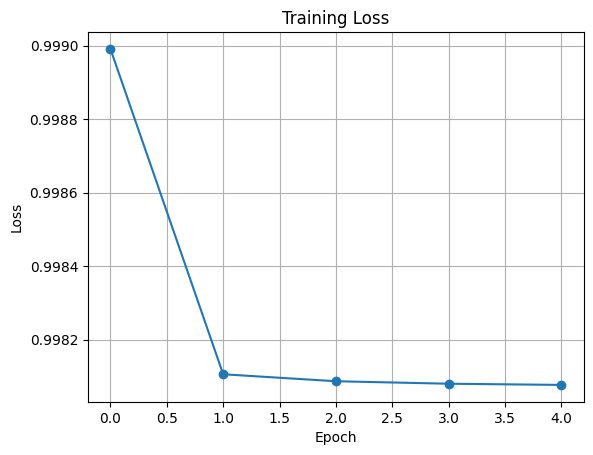

In [16]:
from torch.utils.data import DataLoader
from dummy_dataset import Dummy3DMedicalDataset

# 构造数据集和 loader
dataset = Dummy3DMedicalDataset(num_samples=100)
loader = DataLoader(dataset, batch_size=2, shuffle=True)

train(model, optimizer, device, epochs=5, dataloader=loader, save_path="checkpoints/spark.pth")

# 数据处理

In [2]:
from scripts.preprocess_amos import preprocess_amos_nii_to_npy

input_dir = "/root/lanyun-tmp/amos_dataset/amos22/imagesTr"
output_dir = "/root/lanyun-tmp/amos_dataset/amos22/npy_patches"
preprocess_amos_nii_to_npy(input_dir, output_dir, patch_size=(64, 64, 64))

Preprocessing AMOS:  23%|██▎       | 50/215 [01:32<03:01,  1.10s/it]

[❌ ERROR] Skipping amos_0098.nii.gz: Compressed file ended before the end-of-stream marker was reached


Preprocessing AMOS: 100%|██████████| 215/215 [07:00<00:00,  1.95s/it]


# 1. 导入 + 设置路径

In [6]:
import os
import sys
import torch
from torch.utils.data import DataLoader
from torch import optim
import matplotlib.pyplot as plt

# 添加自定义模块路径
sys.path.append(os.path.abspath("../utils"))
sys.path.append(os.path.abspath("../models"))
sys.path.append(os.path.abspath("../scripts"))
sys.path.append("/root/Implementation")  # 假设 scripts 在 /root/scripts 下

from train import train
from simple_cnn import Simple3DCNNEncoder
from decoder3D import LightDecoder
from encoder3D import SparseEncoder
from AnatoMask import SparK
from real_dataset import Real3DMedicalDataset
from checkpoint import save_checkpoint, load_checkpoint

# 2. 超参数设置

In [2]:
# ====== Config ======
PATCH_SIZE = (64, 64, 64)
BATCH_SIZE = 2
EPOCHS = 10
LR = 1e-4
DATA_DIR = "/root/lanyun-tmp/amos_dataset/amos22/npy_patches"
CHECKPOINT_PATH = "checkpoints/anatomask_real.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#  3. 模型构建

In [3]:
cnn = Simple3DCNNEncoder(in_channels=1, base_channels=64)
encoder = SparseEncoder(cnn, input_size=PATCH_SIZE, sbn=False)
decoder = LightDecoder(up_sample_ratio=8, width=256, sbn=False)
model = SparK(encoder, decoder, mask_ratio=0.6).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LR)

[SparK.__init__, densify 1/3]: use nn.Identity() as densify_proj
[SparK.__init__, densify 2/3]: densify_proj(ksz=3, #para=0.44M)
[SparK.__init__, densify 3/3]: densify_proj(ksz=3, #para=0.11M)
[SparK.__init__] dims of mask_tokens=(256, 128, 64)


# 4. 数据加载

In [4]:
dataset = Real3DMedicalDataset(DATA_DIR)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# 5. 训练函数封装

In [5]:
def train_one_epoch(model, optimizer, device, epoch, total_epochs, dataloader):
    model.train()
    epoch_loss = []

    for x in dataloader:
        x = x.to(device)
        rand_mask = model.mask(x.shape[0], device)
        inp, rec = model(x, active_b1ff=rand_mask)
        _, patch_loss = model.forward_loss(inp, rec, rand_mask)

        anatomask_mask, _ = model.generate_mask(patch_loss, epoch=epoch, total_epoch=total_epochs)
        inp2, rec2 = model(x, active_b1ff=anatomask_mask)
        loss, _ = model.forward_loss(inp2, rec2, anatomask_mask)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())

    return sum(epoch_loss) / len(epoch_loss)

def train(model, optimizer, device, epochs, dataloader, save_path=None):
    loss_history = []
    for epoch in range(epochs):
        loss = train_one_epoch(model, optimizer, device, epoch, epochs, dataloader)
        loss_history.append(loss)
        print(f"[Epoch {epoch+1}/{epochs}] Loss: {loss:.6f}")
        if save_path:
            save_checkpoint(model, optimizer, epoch, save_path)
            print(f"✅ 模型已保存: {save_path}")
    plt.plot(loss_history, marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")
    plt.grid(True)
    plt.show()

# 6. 启动训练

In [ ]:
train(model, optimizer, DEVICE, epochs=EPOCHS, dataloader=loader, save_path=CHECKPOINT_PATH)